# Classificatore basato su SVM lineari e n-grammi

Il secondo classificatore dovrà anch'esso basarsi su un SVM lineare, ma utilizzando una rappresentazione del testo fondata su n-grammi di caratteri, parole e part-of-speech. Lo studente dovrà:
- sperimentare diverse configurazioni della rappresentazione testuale, variando sia la lunghezza degli n-grammi sia il tipo di informazione linguistica impiegata (forme, lemmi, caratteri, POS);
- confrontare le prestazioni delle diverse configurazioni sul validation set;
- selezionare il sistema più performante e valutarlo sul test set.

In [87]:
import numpy as np
import os

Comportamento con le preposizioni articolate: prendiamo direttamente gli split

In [88]:
dataset_conllu = "Dataset conllu/"

## Definizione delle classi Document, Sentence e Token

In [89]:
# Documento come lista di frasi, ogni frase è un elemento di sentence.
# A ogni documento sono associati id, split, etichetta autrice e features
# Dataset conllu/Test/colombi_101_test.conllu
class Document:
    
    def __init__(self, document_path):
        self.document_path = document_path
        self.doc_id = None
        self.split = None
        self.autrice = None
        self._load_doc_info(document_path)
        self.sentences = []
        self.features = None

    # Estraggo le informazioni su id, autrice e split dal nome del file
    def _load_doc_info(self, document_path):
        # doc_id = autrice_n_split
        self.doc_id = (document_path.split('.')[0]).split("/")[-1]
        self.split = self.doc_id.split('_')[-1]
        self.autrice = self.doc_id.split('_')[0]

    # metodo per aggiungere la frase al documento    
    def add_sentence(self, sentence):
        self.sentences.append(sentence)
    
    # metodi accessori: n-token, n-caratteri
    def get_num_tokens(self):
        num_words = 0
        for sentence in self.sentences:
            num_words = num_words + sentence.get_num_tokens()
        return num_words
    
    def get_num_chars(self):
        num_chars = 0
        for sentence in self.sentences:
            sentence_char_len = sentence.get_num_chars()
            num_chars = num_chars + sentence_char_len
        return num_chars
        
# Sentence come lista di token        
class Sentence:
    
    def __init__(self):
        self.tokens = []
    
    # appendo alla lista gli oggetti token che incontro
    def add_token(self, token):
        self.tokens.append(token)
    
    # metodi per ottenere parole, lemmi, pos, n-token e n-caratteri
        
    def get_words(self):
        return [token.word for token in self.tokens]
    
    def get_lemmas(self):
        return [token.lemma for token in self.tokens]
    
    def get_pos(self):
        return [token.pos for token in self.tokens]
    
    def get_num_tokens(self):
        return len(self.tokens)
    
    def get_num_chars(self):
        num_chars = 0
        for token in self.tokens:
            num_chars = num_chars + token.get_num_chars()
        num_chars = num_chars + self.get_num_tokens() - 1 # contiamo anche gli spazi
        return num_chars
    
    # stampa le forme all'interno della frase separate da spazi
    def __str__(self):
        return ' '.join([token.word for token in self.tokens])

class Token:
    
    def __init__(self, word, lemma, pos):
        self.word = word
        self.lemma = lemma
        self.pos = pos
        
    # Numero di caratteri del token
        
    def get_num_chars(self):
        return len(self.word)

In [90]:
# funzione di caricamento delle frasi nel documento
def load_document_sentences(document):
    sentence = Sentence()
    for line in open(document.document_path, 'r'):    
        if line[0].isdigit():  # se la riga inizia con un numero sono in corrispondenza di un token
            # splitto i campi
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino
                # creo il token assegnandoli forma, lemma e pos
                token = Token(splitted_line[1], splitted_line[2], splitted_line[3])
                sentence.add_token(token)
        if line == '\n':  # se la riga è vuota significa che la frase è finita
            document.add_sentence(sentence)
            sentence = Sentence()

In [91]:
# Carico tutti i documenti sulla stessa lista, così da ottenere features comuni nelle fasi successive
lista_documenti = []

for cartella, sottocartelle, files in os.walk(dataset_conllu):
    for file in files:
        if file.endswith(".conllu"):
            file_path = cartella+"/"+file
            document = Document(file_path)
            load_document_sentences(document)
            lista_documenti.append(document)  


In [92]:
sample_document = lista_documenti[1]
print("Questo è il documento: "+sample_document.doc_id)
for sentence in sample_document.sentences[:5]:
    tokens = [token.word for token in sentence.tokens]
    print(' - '.join(tokens)+'\n')

Questo è il documento: colombi_190_test
Ordinai - quella - bibita - con - tanta - premura - che - dovettero - credere - che - mi - prendesse - male - .

Poi - m' - inquietai - che - non - fosse - lì - subito - , - e - in - il - tempo - che - il - cameriere - impiegò - a - scendere - le - scale - e - risalire - , - mi - pentii - dieci - volte - di - aver - dato - quell' - ordine - , - e - mi - spaventai - a - l' - idea - d' - essere - scoperta - da - Max - prendendo - il - caffè - , - come - non - so - di - che - umiliazione - .

Appena - fu - recato - il - vassoio - , - dissi - a - il - cameriere - di - aspettare - , - ed - afferrata - la - tazza - ingollai - tutto - il - caffè - bollente - in - un - fiato - , - bruciando - mi - la - bocca - e - lo - stomaco - , - e - rimandai - tosto - il - servo - con - il - corpo - di - il - delitto - .



In [93]:
print(len(lista_documenti))

3600


## Estrazione n-grammi (features)

Definizione delle funzioni per l'estrazione

In [94]:
sample_sentence = sample_document.sentences[2]
print(sample_sentence)

Appena fu recato il vassoio , dissi a il cameriere di aspettare , ed afferrata la tazza ingollai tutto il caffè bollente in un fiato , bruciando mi la bocca e lo stomaco , e rimandai tosto il servo con il corpo di il delitto .


#### n-grammi di parola

In [95]:
def extract_word_ngrams_from_sentence(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    if el == 'word':
        all_words = sentence.get_words()
    elif el == 'lemma':
        all_words = sentence.get_lemmas()
    elif el == 'pos':
        all_words = sentence.get_pos()
    else:
        raise Exception(f'Invalid element {el}')
    
    # scorriamo la lista delle parole ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1): # -n+1 serve per non uscire dal vettore
        ngram_words = all_words[i: i + n]
        # mi dice di cos'è l'n-gramma (parole, pos o lemmi) - nome della label
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        # print(f'{i}: {ngram_words} -> {ngram}')
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1

    return word_ngrams

In [96]:
extract_word_ngrams_from_sentence(dict(), sample_sentence, 'word', 1)

{'WORD_1_Appena': 1,
 'WORD_1_fu': 1,
 'WORD_1_recato': 1,
 'WORD_1_il': 6,
 'WORD_1_vassoio': 1,
 'WORD_1_,': 4,
 'WORD_1_dissi': 1,
 'WORD_1_a': 1,
 'WORD_1_cameriere': 1,
 'WORD_1_di': 2,
 'WORD_1_aspettare': 1,
 'WORD_1_ed': 1,
 'WORD_1_afferrata': 1,
 'WORD_1_la': 2,
 'WORD_1_tazza': 1,
 'WORD_1_ingollai': 1,
 'WORD_1_tutto': 1,
 'WORD_1_caffè': 1,
 'WORD_1_bollente': 1,
 'WORD_1_in': 1,
 'WORD_1_un': 1,
 'WORD_1_fiato': 1,
 'WORD_1_bruciando': 1,
 'WORD_1_mi': 1,
 'WORD_1_bocca': 1,
 'WORD_1_e': 2,
 'WORD_1_lo': 1,
 'WORD_1_stomaco': 1,
 'WORD_1_rimandai': 1,
 'WORD_1_tosto': 1,
 'WORD_1_servo': 1,
 'WORD_1_con': 1,
 'WORD_1_corpo': 1,
 'WORD_1_delitto': 1,
 'WORD_1_.': 1}

#### n-grammi di carattere

In [97]:
def extract_char_ngrams_from_sentence(char_ngrams, sentence, n):
    # creiamo una lista con tutte le parole
    all_words = sentence.get_words()

    # creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    # print(all_words)
    # all_words = all_words.lower()

    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars
        # print(f'{i}: {ngram_chars} -> {ngram}')

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1

    return char_ngrams

In [98]:
extract_char_ngrams_from_sentence(dict(), sample_sentence, 2)

{'CHAR_2_Ap': 1,
 'CHAR_2_pp': 1,
 'CHAR_2_pe': 2,
 'CHAR_2_en': 2,
 'CHAR_2_na': 1,
 'CHAR_2_a ': 7,
 'CHAR_2_ f': 2,
 'CHAR_2_fu': 1,
 'CHAR_2_u ': 1,
 'CHAR_2_ r': 2,
 'CHAR_2_re': 3,
 'CHAR_2_ec': 1,
 'CHAR_2_ca': 4,
 'CHAR_2_at': 3,
 'CHAR_2_to': 7,
 'CHAR_2_o ': 11,
 'CHAR_2_ i': 8,
 'CHAR_2_il': 6,
 'CHAR_2_l ': 6,
 'CHAR_2_ v': 1,
 'CHAR_2_va': 1,
 'CHAR_2_as': 2,
 'CHAR_2_ss': 2,
 'CHAR_2_so': 1,
 'CHAR_2_oi': 1,
 'CHAR_2_io': 1,
 'CHAR_2_ ,': 4,
 'CHAR_2_, ': 4,
 'CHAR_2_ d': 4,
 'CHAR_2_di': 3,
 'CHAR_2_is': 1,
 'CHAR_2_si': 1,
 'CHAR_2_i ': 6,
 'CHAR_2_ a': 3,
 'CHAR_2_ c': 4,
 'CHAR_2_am': 1,
 'CHAR_2_me': 1,
 'CHAR_2_er': 4,
 'CHAR_2_ri': 2,
 'CHAR_2_ie': 1,
 'CHAR_2_e ': 5,
 'CHAR_2_sp': 1,
 'CHAR_2_et': 1,
 'CHAR_2_tt': 3,
 'CHAR_2_ta': 3,
 'CHAR_2_ar': 1,
 'CHAR_2_ e': 3,
 'CHAR_2_ed': 1,
 'CHAR_2_d ': 1,
 'CHAR_2_af': 2,
 'CHAR_2_ff': 2,
 'CHAR_2_fe': 1,
 'CHAR_2_rr': 1,
 'CHAR_2_ra': 1,
 'CHAR_2_ l': 3,
 'CHAR_2_la': 3,
 'CHAR_2_ t': 3,
 'CHAR_2_az': 1,
 'CHAR_2_zz':

In [99]:
print(sample_document.features)

None


#### Funzione di normalizzazione

In [100]:
# Funzione di normalizzazione utile perché i paragrafi hanno lunghezza differente
# (normalizza sulla frequenza)
def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram] / float(doc_len)

#### Funzione che permette di estrarre gli n-grammi dai tipi di informazione scelti

In [101]:
# creo una funzione che mi permetta di variare la lunghezza degli n-grammi e il tipo di informazione 
# linguistica impiegata (forme, lemmi, caratteri, POS)
def extract_documents_ngrams_normalized(all_documents, lista_features):

        # scorro i documenti, creo per ciascuno un dizionario
        for document in all_documents:
            dizionario_features = dict()
            
            # scorro la lista di feature, per ciascuna lancio la funzione corrispondente
            for el in lista_features:
                tipologia = el[0]
                cardinalità = el[1]
                dizionario_el = dict()
                for sentence in document.sentences:
                    # se l'elemento è caratteri, chiamo la funzione specifica
                    if tipologia == "char":
                        extract_char_ngrams_from_sentence(dizionario_el, sentence, cardinalità)
                        # salvo il numero di caratteri
                        num_elements = document.get_num_chars()

                    # altrimenti chiamo la funzione per parole, pos e lemmi
                    else:
                        extract_word_ngrams_from_sentence(dizionario_el, sentence, tipologia, cardinalità)
                        # salvo il numero di token
                        num_elements = document.get_num_tokens()
                # normalizzo
                normalize_ngrams(dizionario_el, num_elements)

                # aggiungo tutte le features estratte per l'elemento
                dizionario_features = dizionario_features | dizionario_el

            # associo al metodo il dizionario che ora contiene tutti gli n-grammi estratti dal documento
            document.features = dizionario_features

## Estrazione delle features dei documenti e valutazione delle performance sul validation set

### Primo tentativo: 1 e 2-grammi di parole, 1 e 2-grammi di caratteri

In [102]:
lista_features = [("word", 1), ("word", 2), ("char", 1), ("char", 2)]
extract_documents_ngrams_normalized(lista_documenti, lista_features)
sample_document.features
#### Divisione training, test e validation set
def train_test_val_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    val_features_dict, val_labels = [], []

    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.autrice)
        elif document.split == 'validation':
            val_features_dict.append(document.features)
            val_labels.append(document.autrice)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.autrice)
    
    return train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels
train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels = train_test_val_split(lista_documenti)
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels), len(val_features_dict), len(val_labels)

train_labels[:5]
#### Filtro delle features poco frequenti
#Per ridurre lo spazio delle features (n-grammi) si possono eliminare tutte quelle che compaiono in meno di tot. documenti.
#Il filtro deve essere calcolato sulle features del training set!
def get_num_features(features_dict):
    all_features = set()
    for document_feats in features_dict:
        all_features.update(list(document_feats.keys()))
    return len(all_features)
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')
def filter_features(train_features_dict, min_occurrences):
    # contiamo ogni feature in quanti documenti diversi compare
    features_counter = dict()
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" documenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict
train_features_dict = filter_features(train_features_dict, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')
#### Creazione del vettore delle features
#Trasformare il dizionario di features in un vettore di lunghezza fissa, che abbia una posizione fissa per ogni feature che compare nel training set. Serve una funzione che mappi ogni feature del dizionario ad una posizione sul vettore.
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
y_train = np.array(train_labels)
X_train
vectorizer.get_feature_names_out(X_train).tolist()
### Normalizzazione delle features
#Utilizzando una matrice sparsa non possiamo usare MinMaxScaler, perchè è importante mantenere la posizione degli 0. Il MinMaxScaler spingerebbe a 0 elementi che non erano 0, e renderebbe diversi da 0 quelli che invece lo erano.
#Utilizziamo MaxAbsScaler che divide ogni feature per il suo massimo in valore assoluto. Le feature non saranno più nell'intervallo [0, 1], ma [-1, 1], e preserveranno la posizione degli 0.
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_X_train = scaler.fit_transform(X_train)
### Addestramento del classificatore
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=True, max_iter=10000)
svc.fit(scaled_X_train, train_labels)
### Prestazioni sul Validation set
X_val = vectorizer.transform(val_features_dict)
scaled_X_val = scaler.transform(X_val)
y_val = np.array(val_labels)
from sklearn.metrics import classification_report

val_predictions = svc.predict(scaled_X_val)
print(classification_report(val_labels, val_predictions, zero_division=0))

Numero features: 143998
Numero features dopo il filtro: 11303
              precision    recall  f1-score   support

     colombi       0.72      0.91      0.81       100
       neera       0.89      0.58      0.70       100
       serao       0.84      0.92      0.88       100

    accuracy                           0.80       300
   macro avg       0.82      0.80      0.80       300
weighted avg       0.82      0.80      0.80       300



### Secondo tentativo: 1 e 2-grammi di parole, 1 e 2-grammi di lemmi

In [103]:
lista_features = [("word", 1), ("word", 2), ("lemma", 1), ("lemma", 2)]
extract_documents_ngrams_normalized(lista_documenti, lista_features)
sample_document.features
#### Divisione training, test e validation set
def train_test_val_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    val_features_dict, val_labels = [], []

    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.autrice)
        elif document.split == 'validation':
            val_features_dict.append(document.features)
            val_labels.append(document.autrice)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.autrice)
    
    return train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels
train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels = train_test_val_split(lista_documenti)
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels), len(val_features_dict), len(val_labels)

train_labels[:5]
#### Filtro delle features poco frequenti
#Per ridurre lo spazio delle features (n-grammi) si possono eliminare tutte quelle che compaiono in meno di tot. documenti.
#Il filtro deve essere calcolato sulle features del training set!
def get_num_features(features_dict):
    all_features = set()
    for document_feats in features_dict:
        all_features.update(list(document_feats.keys()))
    return len(all_features)
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')
def filter_features(train_features_dict, min_occurrences):
    # contiamo ogni feature in quanti documenti diversi compare
    features_counter = dict()
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" documenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict
train_features_dict = filter_features(train_features_dict, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')
#### Creazione del vettore delle features
#Trasformare il dizionario di features in un vettore di lunghezza fissa, che abbia una posizione fissa per ogni feature che compare nel training set. Serve una funzione che mappi ogni feature del dizionario ad una posizione sul vettore.
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
y_train = np.array(train_labels)
X_train
vectorizer.get_feature_names_out(X_train).tolist()
### Normalizzazione delle features
#Utilizzando una matrice sparsa non possiamo usare MinMaxScaler, perchè è importante mantenere la posizione degli 0. Il MinMaxScaler spingerebbe a 0 elementi che non erano 0, e renderebbe diversi da 0 quelli che invece lo erano.

#Utilizziamo MaxAbsScaler che divide ogni feature per il suo massimo in valore assoluto. Le feature non saranno più nell'intervallo [0, 1], ma [-1, 1], e preserveranno la posizione degli 0.
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_X_train = scaler.fit_transform(X_train)
### Addestramento del classificatore
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=True, max_iter=10000)
svc.fit(scaled_X_train, train_labels)
### Prestazioni sul Validation set
X_val = vectorizer.transform(val_features_dict)
scaled_X_val = scaler.transform(X_val)
y_val = np.array(val_labels)
from sklearn.metrics import classification_report

val_predictions = svc.predict(scaled_X_val)
print(classification_report(val_labels, val_predictions, zero_division=0))

Numero features: 251619
Numero features dopo il filtro: 20986
              precision    recall  f1-score   support

     colombi       0.70      0.94      0.80       100
       neera       0.91      0.58      0.71       100
       serao       0.90      0.92      0.91       100

    accuracy                           0.81       300
   macro avg       0.84      0.81      0.81       300
weighted avg       0.84      0.81      0.81       300



### Terzo tentativo: 1 e 2-grammi di parole, 1 e 2-grammi di POS

In [104]:
lista_features = [("word", 1), ("word", 2), ("pos", 1), ("pos", 2)]
extract_documents_ngrams_normalized(lista_documenti, lista_features)

In [105]:
sample_document.features

{'WORD_1_Ordinai': 0.008620689655172414,
 'WORD_1_quella': 0.008620689655172414,
 'WORD_1_bibita': 0.008620689655172414,
 'WORD_1_con': 0.017241379310344827,
 'WORD_1_tanta': 0.008620689655172414,
 'WORD_1_premura': 0.008620689655172414,
 'WORD_1_che': 0.04310344827586207,
 'WORD_1_dovettero': 0.008620689655172414,
 'WORD_1_credere': 0.008620689655172414,
 'WORD_1_mi': 0.034482758620689655,
 'WORD_1_prendesse': 0.008620689655172414,
 'WORD_1_male': 0.008620689655172414,
 'WORD_1_.': 0.02586206896551724,
 'WORD_1_Poi': 0.008620689655172414,
 "WORD_1_m'": 0.008620689655172414,
 'WORD_1_inquietai': 0.008620689655172414,
 'WORD_1_non': 0.017241379310344827,
 'WORD_1_fosse': 0.008620689655172414,
 'WORD_1_lì': 0.008620689655172414,
 'WORD_1_subito': 0.008620689655172414,
 'WORD_1_,': 0.06896551724137931,
 'WORD_1_e': 0.04310344827586207,
 'WORD_1_in': 0.017241379310344827,
 'WORD_1_il': 0.07758620689655173,
 'WORD_1_tempo': 0.008620689655172414,
 'WORD_1_cameriere': 0.017241379310344827,
 '

#### Divisione training, test e validation set

In [106]:
def train_test_val_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    val_features_dict, val_labels = [], []

    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.autrice)
        elif document.split == 'validation':
            val_features_dict.append(document.features)
            val_labels.append(document.autrice)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.autrice)
    
    return train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels

In [107]:
train_features_dict, train_labels, test_features_dict, test_labels, val_features_dict, val_labels = train_test_val_split(lista_documenti)

In [108]:
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels), len(val_features_dict), len(val_labels)


(3000, 3000, 300, 300, 300, 300)

In [109]:
train_labels[:5]

['neera', 'neera', 'serao', 'colombi', 'neera']

#### Filtro delle features poco frequenti

Per ridurre lo spazio delle features (n-grammi) si possono eliminare tutte quelle che compaiono in meno di tot. documenti.

Il filtro deve essere calcolato sulle features del training set!

In [110]:
def get_num_features(features_dict):
    all_features = set()
    for document_feats in features_dict:
        all_features.update(list(document_feats.keys()))
    return len(all_features)

In [111]:
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')

Numero features: 143054


In [112]:
def filter_features(train_features_dict, min_occurrences):
    # contiamo ogni feature in quanti documenti diversi compare
    features_counter = dict()
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" documenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict

In [113]:
train_features_dict = filter_features(train_features_dict, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')

Numero features dopo il filtro: 10764


#### Creazione del vettore delle features

Trasformare il dizionario di features in un vettore di lunghezza fissa, che abbia una posizione fissa per ogni feature che compare nel training set. Serve una funzione che mappi ogni feature del dizionario ad una posizione sul vettore.

In [114]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
y_train = np.array(train_labels)

In [115]:
X_train

<3000x10764 sparse matrix of type '<class 'numpy.float64'>'
	with 399437 stored elements in Compressed Sparse Row format>

In [116]:
vectorizer.get_feature_names_out(X_train).tolist()

['POS_1_ADJ',
 'POS_1_ADP',
 'POS_1_ADV',
 'POS_1_AUX',
 'POS_1_CCONJ',
 'POS_1_DET',
 'POS_1_INTJ',
 'POS_1_NOUN',
 'POS_1_NUM',
 'POS_1_PRON',
 'POS_1_PROPN',
 'POS_1_PUNCT',
 'POS_1_SCONJ',
 'POS_1_VERB',
 'POS_1_X',
 'POS_2_ADJ_ADJ',
 'POS_2_ADJ_ADP',
 'POS_2_ADJ_ADV',
 'POS_2_ADJ_AUX',
 'POS_2_ADJ_CCONJ',
 'POS_2_ADJ_DET',
 'POS_2_ADJ_NOUN',
 'POS_2_ADJ_NUM',
 'POS_2_ADJ_PRON',
 'POS_2_ADJ_PROPN',
 'POS_2_ADJ_PUNCT',
 'POS_2_ADJ_SCONJ',
 'POS_2_ADJ_VERB',
 'POS_2_ADP_ADJ',
 'POS_2_ADP_ADP',
 'POS_2_ADP_ADV',
 'POS_2_ADP_AUX',
 'POS_2_ADP_DET',
 'POS_2_ADP_NOUN',
 'POS_2_ADP_NUM',
 'POS_2_ADP_PRON',
 'POS_2_ADP_PROPN',
 'POS_2_ADP_PUNCT',
 'POS_2_ADP_SCONJ',
 'POS_2_ADP_VERB',
 'POS_2_ADV_ADJ',
 'POS_2_ADV_ADP',
 'POS_2_ADV_ADV',
 'POS_2_ADV_AUX',
 'POS_2_ADV_CCONJ',
 'POS_2_ADV_DET',
 'POS_2_ADV_NOUN',
 'POS_2_ADV_NUM',
 'POS_2_ADV_PRON',
 'POS_2_ADV_PROPN',
 'POS_2_ADV_PUNCT',
 'POS_2_ADV_SCONJ',
 'POS_2_ADV_VERB',
 'POS_2_AUX_ADJ',
 'POS_2_AUX_ADP',
 'POS_2_AUX_ADV',
 'POS_2_AUX

#### Normalizzazione delle features

Utilizzando una matrice sparsa non possiamo usare MinMaxScaler, perchè è importante mantenere la posizione degli 0. Il MinMaxScaler spingerebbe a 0 elementi che non erano 0, e renderebbe diversi da 0 quelli che invece lo erano.

Utilizziamo MaxAbsScaler che divide ogni feature per il suo massimo in valore assoluto. Le feature non saranno più nell'intervallo [0, 1], ma [-1, 1], e preserveranno la posizione degli 0.

In [117]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_X_train = scaler.fit_transform(X_train)

#### Addestramento del classificatore

In [118]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=True, max_iter=10000)
svc.fit(scaled_X_train, train_labels)

LinearSVC(dual=True, max_iter=10000)

#### Prestazioni sul Validation set

In [119]:
X_val = vectorizer.transform(val_features_dict)
scaled_X_val = scaler.transform(X_val)
y_val = np.array(val_labels)

In [120]:
from sklearn.metrics import classification_report

val_predictions = svc.predict(scaled_X_val)
print(classification_report(val_labels, val_predictions, zero_division=0))

              precision    recall  f1-score   support

     colombi       0.78      0.93      0.85       100
       neera       0.93      0.70      0.80       100
       serao       0.89      0.93      0.91       100

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



## Prestazioni sul Test set della configurazione più performante

Eseguite sul terzo tentativo: 1 e 2-grammi di parole, 1 e 2-grammi di POS, che ha dato i migliori risultati (accuracy 0.85)

In [121]:
X_test = vectorizer.transform(test_features_dict)
scaled_X_test = scaler.transform(X_test)
y_test = np.array(test_labels)

In [122]:
from sklearn.metrics import classification_report

test_predictions = svc.predict(scaled_X_test)
print(classification_report(test_labels, test_predictions, zero_division=0))

              precision    recall  f1-score   support

     colombi       0.78      0.93      0.85       100
       neera       0.93      0.80      0.86       100
       serao       0.89      0.85      0.87       100

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300



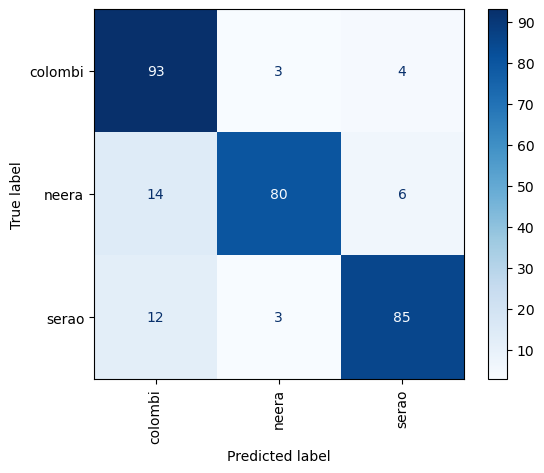

In [123]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues')

#### Feature importance


In [124]:
svc.classes_

array(['colombi', 'neera', 'serao'], dtype='<U7')

In [125]:
coefs = svc.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape

(3, 10764)

In [126]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names

['POS_1_ADJ',
 'POS_1_ADP',
 'POS_1_ADV',
 'POS_1_AUX',
 'POS_1_CCONJ',
 'POS_1_DET',
 'POS_1_INTJ',
 'POS_1_NOUN',
 'POS_1_NUM',
 'POS_1_PRON',
 'POS_1_PROPN',
 'POS_1_PUNCT',
 'POS_1_SCONJ',
 'POS_1_VERB',
 'POS_1_X',
 'POS_2_ADJ_ADJ',
 'POS_2_ADJ_ADP',
 'POS_2_ADJ_ADV',
 'POS_2_ADJ_AUX',
 'POS_2_ADJ_CCONJ',
 'POS_2_ADJ_DET',
 'POS_2_ADJ_NOUN',
 'POS_2_ADJ_NUM',
 'POS_2_ADJ_PRON',
 'POS_2_ADJ_PROPN',
 'POS_2_ADJ_PUNCT',
 'POS_2_ADJ_SCONJ',
 'POS_2_ADJ_VERB',
 'POS_2_ADP_ADJ',
 'POS_2_ADP_ADP',
 'POS_2_ADP_ADV',
 'POS_2_ADP_AUX',
 'POS_2_ADP_DET',
 'POS_2_ADP_NOUN',
 'POS_2_ADP_NUM',
 'POS_2_ADP_PRON',
 'POS_2_ADP_PROPN',
 'POS_2_ADP_PUNCT',
 'POS_2_ADP_SCONJ',
 'POS_2_ADP_VERB',
 'POS_2_ADV_ADJ',
 'POS_2_ADV_ADP',
 'POS_2_ADV_ADV',
 'POS_2_ADV_AUX',
 'POS_2_ADV_CCONJ',
 'POS_2_ADV_DET',
 'POS_2_ADV_NOUN',
 'POS_2_ADV_NUM',
 'POS_2_ADV_PRON',
 'POS_2_ADV_PROPN',
 'POS_2_ADV_PUNCT',
 'POS_2_ADV_SCONJ',
 'POS_2_ADV_VERB',
 'POS_2_AUX_ADJ',
 'POS_2_AUX_ADP',
 'POS_2_AUX_ADV',
 'POS_2_AUX

Feature importance classe colombi


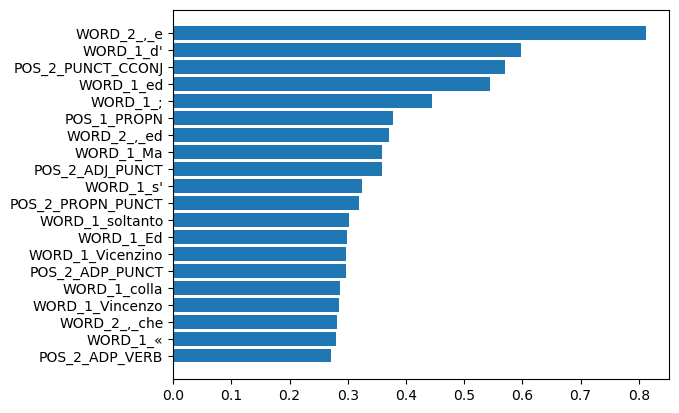

In [127]:
import matplotlib.pyplot as plt

idx = 0
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 20
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()
plt.show()

Feature importance classe neera


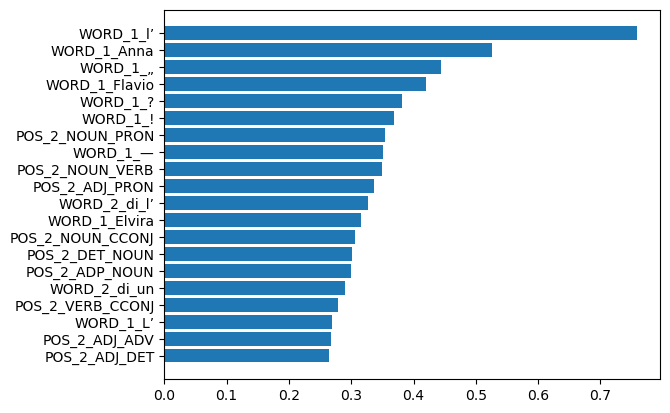

In [128]:
idx = 1
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 20
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()
plt.show()

Feature importance classe serao


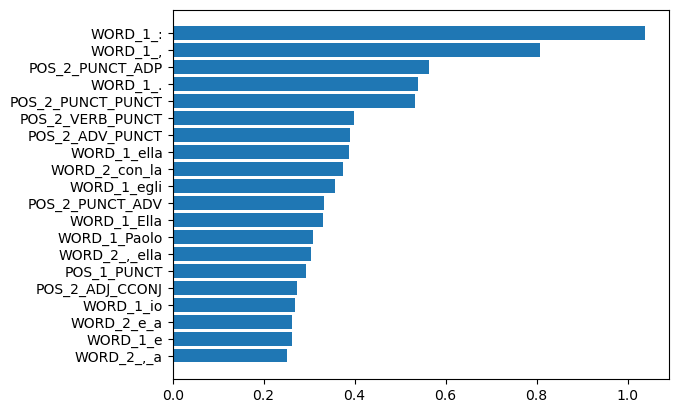

In [129]:
idx = 2
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 20
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()
plt.show()